In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pysal
import contextily
from sklearn.cluster import DBSCAN
import scipy
import pydeck as pdk


# Load the data by excel sheet
df_O = pd.read_csv('orginization.csv')
df_R = pd.read_csv('route.csv')
df_TR = pd.read_csv('trip_request.csv')
df_V = pd.read_csv('vehicle.csv')
df_TS = pd.read_csv('trip_summary.csv')

dataframes = {"DataFrame 1": df_O, "DataFrame 2":df_R, "DataFrame 3":df_TR, "DataFrame 4":df_V, "DataFrame 5":df_TS}


# Summary of the Data 

In [4]:
# Print Summary of Data
for name, df in dataframes.items():
    print(f"Summary for {name}:")
    print(df.describe(), "\n", "\n", "\n")

Summary for DataFrame 1:
       organization_id
count        26.000000
mean         25.384615
std          12.840800
min           1.000000
25%          14.750000
50%          26.500000
75%          36.500000
max          43.000000 
 
 

Summary for DataFrame 2:
                  id     driver_id   vehicle_id  ambulatory_riders  \
count    8110.000000   8109.000000  8110.000000        8110.000000   
mean   147719.580148   7057.956715    73.279901           6.432676   
std     13438.307900   7217.561622    68.760618           5.223347   
min    120378.000000      6.000000     5.000000           0.000000   
25%    136103.000000     45.000000    42.000000           1.000000   
50%    144974.000000   2733.000000    55.000000           4.000000   
75%    158883.000000  15602.000000    81.000000          12.000000   
max    176204.000000  26734.000000   253.000000          24.000000   

       handicapped_riders  total_riders  
count         8110.000000   8110.000000  
mean             0.119

Correlation table for the route dataset

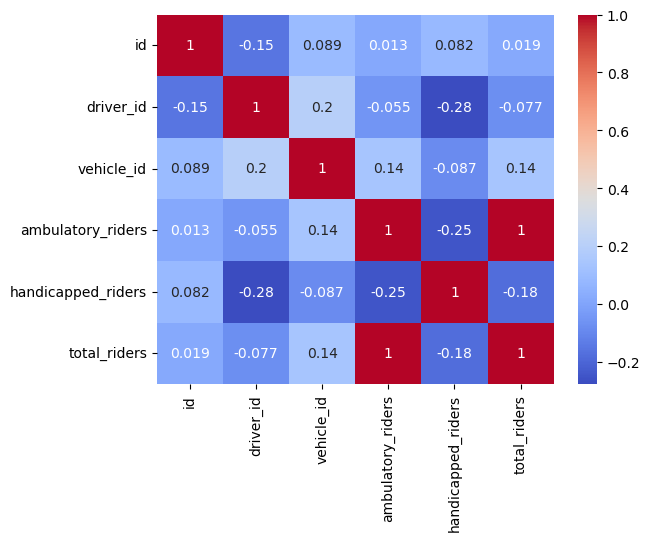

In [5]:
correlation = df_R.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

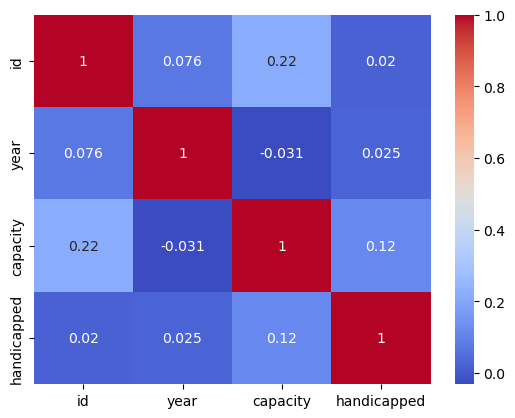

In [7]:
correlation = df_V.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

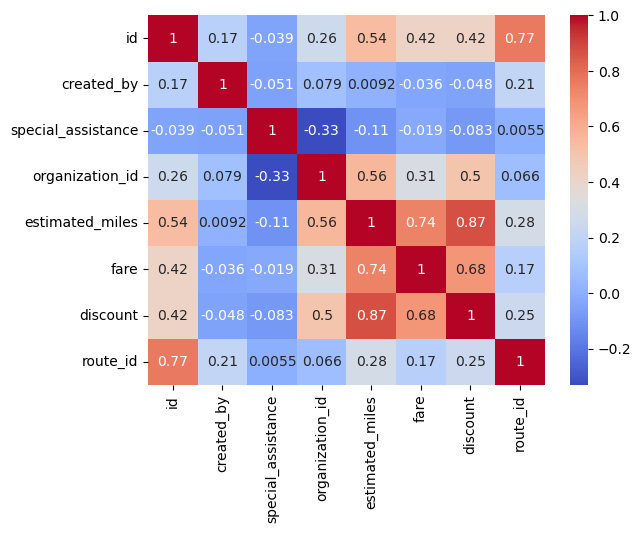

In [8]:
correlation = df_TR.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

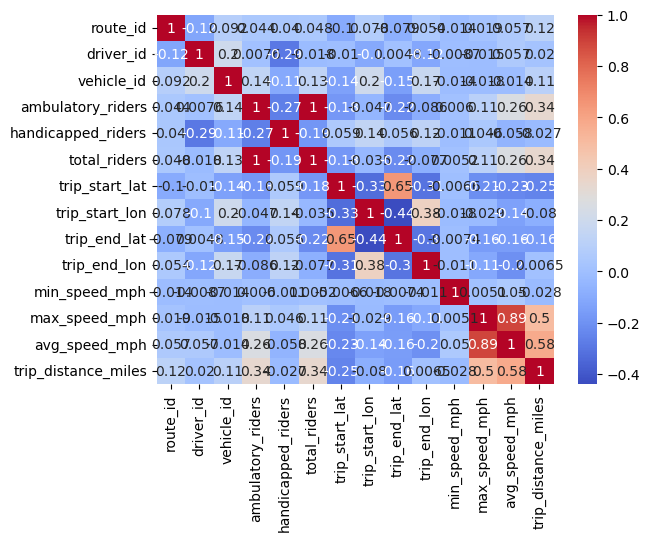

In [9]:
correlation = df_TS.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [11]:
def remove_outliers_zscore(df, col_name):
    z_score = np.abs(df[col_name] - df[col_name].mean()) / df[col_name].std()
    df_without_outliers = df[z_score < 3]
    return df_without_outliers

df_without_outliers_longitude = remove_outliers_zscore(df_TS, 'trip_start_lon')
df_without_outliers_latitude = remove_outliers_zscore(df_TS, 'trip_start_lat')

df_location = df_without_outliers_longitude[['trip_start_lon', 'trip_start_lat']]

print(df_location)

      trip_start_lon  trip_start_lat
0         -82.889196       39.942489
1         -82.917463       39.984225
2         -82.916939       39.984146
3         -82.916930       39.984447
4         -83.141044       40.105410
...              ...             ...
5782      -82.967984       39.971104
5783      -82.792662       39.985720
5784      -82.965085       40.085356
5785      -83.086840       40.096163
5786      -82.947974       40.010079

[5480 rows x 2 columns]


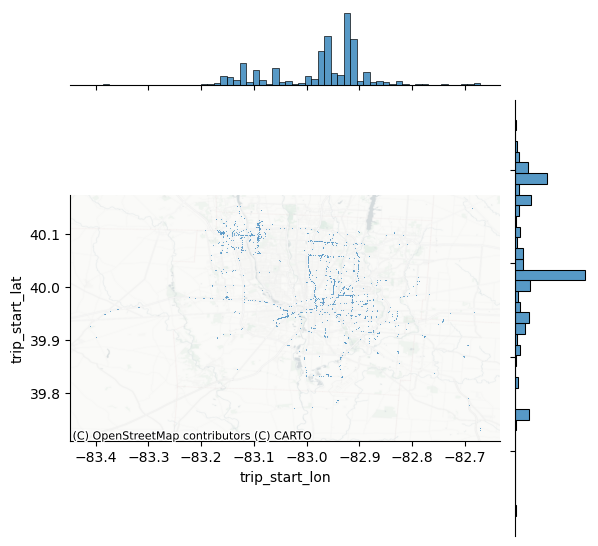

In [12]:
joint_axes = sns.jointplot(x="trip_start_lon", y="trip_start_lat", data=df_location, s=0.5);
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_location_data = scaler.fit_transform(df_location[['trip_start_lon', 'trip_start_lat']])

clusterer = DBSCAN(eps=1000, min_samples=5)
clusterer.fit(scaled_location_data)

DBSCAN(eps=1000)

/Users/suvan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


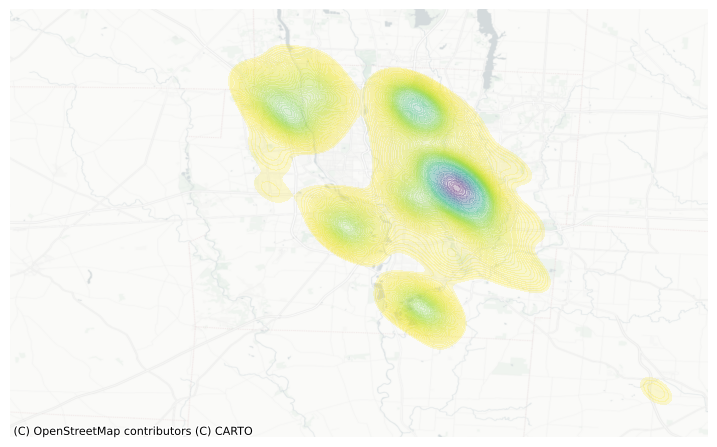

In [15]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
sns.kdeplot(
    df_location["trip_start_lon"],
    df_location["trip_start_lat"],
    n_levels=100,
    shade=True,
    alpha=0.20,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels
)
# Remove axes
ax.set_axis_off()

# DB Cluster Analysis


Using ML to understand the overall clustering of our sample:
DB Scan has these parameters: 


    Noise, for those points outside a cluster.

    Cores, for those points inside a cluster with at least m points in the cluster within distance r.

    Borders for points inside a cluster with less than m other points in the cluster within distance r.


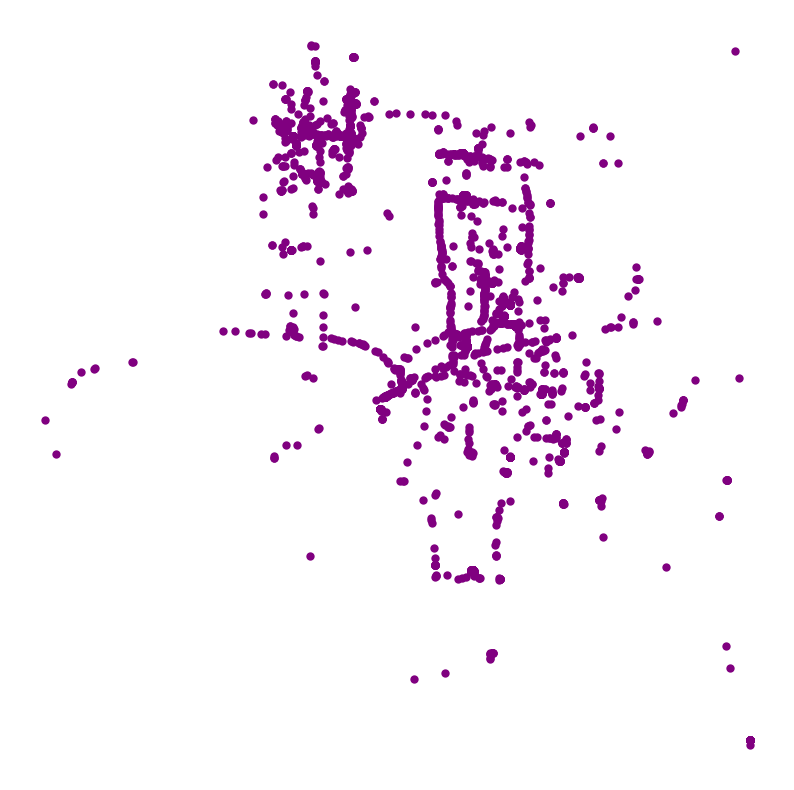

In [16]:


# Define DBSCAN - eps is max radius, min_samples is noise
clusterer = DBSCAN(eps=1000, min_samples=55)
clusterer.fit(df_location[['trip_start_lon', 'trip_start_lat']])

clusterer.core_sample_indices_[:5]
clusterer.labels_[:5]
lbls = pd.Series(clusterer.labels_, index=df_location.index)

#---------Graphing------


# Setup figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))
# Subset points that are not part of any cluster (noise)
noise = df_location.loc[lbls == -1, ["trip_start_lon", "trip_start_lat"]]
# Plot noise in grey
ax.scatter(noise["trip_start_lon"], noise["trip_start_lat"], c="grey", s=5, linewidth=0)

ax.scatter(
    df_location.loc[df_location.index.difference(noise.index), "trip_start_lon"],
    df_location.loc[df_location.index.difference(noise.index), "trip_start_lat"],
    c="purple",
    linewidth=0,
)

# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

In [17]:
from sklearn.cluster import KMeans
import numpy as np

# Number of clusters
kmeans = KMeans(n_clusters=30)

# Fitting the input data
kmeans = kmeans.fit(df_location[['trip_start_lon', 'trip_start_lat']])

# Getting the values of centroids and labels based on input data
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Display the found clusters
df_location["cluster"] = labels
print(df_location.groupby("cluster").size())

cluster
0     1682
1      352
2       36
3      614
4       29
5      361
6       45
7       46
8       56
9      283
10     306
11     294
12      76
13      13
14     168
15      37
16      80
17     208
18      23
19      20
20      10
21      30
22     199
23      59
24     147
25      52
26      69
27      39
28     101
29      45
dtype: int64


/var/folders/zw/g36h_k5s02q7_zm370bn25pw0000gn/T/ipykernel_69457/3903004845.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["cluster"] = labels


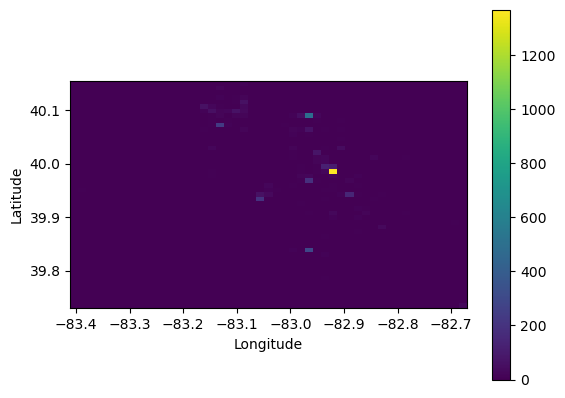

In [18]:

# Define the latitude and longitude data
lat = df_location["trip_start_lat"].values
lon = df_location["trip_start_lon"].values

# Define the number of bins in each direction
bins_x = np.linspace(np.min(lon), np.max(lon), 50)
bins_y = np.linspace(np.min(lat), np.max(lat), 50)

# Create the 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=[bins_x, bins_y])

# Plot the 2D histogram as an image
plt.imshow(hist.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar()

# Add labels and show the plot
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [19]:

def get_significant_pairs(df, col_x, col_y, significance_level=0.05):
    # Calculate the mean and standard deviation for each column
    mean_x = df[col_x].mean()
    mean_y = df[col_y].mean()
    std_x = df[col_x].std()
    std_y = df[col_y].std()
    
    # Calculate the z-score for each pair of values in the two columns
    z_x = (df[col_x] - mean_x) / std_x
    z_y = (df[col_y] - mean_y) / std_y
    
    # Combine the z-scores into pairs
    z_pairs = pd.DataFrame({'z_x': z_x, 'z_y': z_y})
    
    # Calculate the critical value for the given significance level
    critical_value = scipy.stats.norm.ppf(1 - significance_level / 2)
    
    # Get the pairs that are statistically significant
    significant_pairs = z_pairs[(np.abs(z_pairs['z_x']) >= critical_value) & (np.abs(z_pairs['z_y']) >= critical_value)]
    
    return significant_pairs

# Example usage
df_significant = get_significant_pairs(df_location, 'trip_start_lat', 'trip_start_lon')
clusters = len(df_significant)

print(df_significant)


           z_x       z_y
27   -3.487893  3.414056
163  -3.487486  3.413272
585  -3.487884  3.412990
1106 -3.487304  3.413382
1122 -3.488131  3.414009
1194 -3.487331  3.413252
1356 -3.487715  3.413633
1878 -3.487552  3.413647
2166 -3.487653  3.413551
2172 -2.109209  2.430958
2333 -2.740147  3.139687
2526 -3.487968  3.413999
2767 -3.487370  3.413418
2801 -3.487480  3.413231
3003 -3.487506  3.413814
3302 -3.487547  3.413640
3307 -3.487699  3.413163
3350 -3.487847  3.413177
3525 -3.487739  3.413528
3637 -3.487901  3.415040
3983 -3.486975  3.413817
4095 -3.487484  3.413698
4173 -3.487417  3.413417
4250 -3.488181  3.413701
4330 -2.912994  3.178967
4669 -3.487966  3.413647
4860 -3.487993  3.414015
4938 -3.487815  3.413520
5229 -3.525353  3.414370
5232  1.985995  3.235378
5586 -3.488486  3.414580


In [20]:
from sklearn.cluster import KMeans
import numpy as np

# Number of clusters
kmeans = KMeans(n_clusters=clusters)

# Fitting the input data
kmeans = kmeans.fit(df_location[['trip_start_lon', 'trip_start_lat']])

# Getting the values of centroids and labels based on input data
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Display the found clusters
df_location["cluster"] = labels
print(df_location.groupby("cluster").size())

cluster
0      164
1      324
2      362
3       98
4       36
5      621
6       29
7     1408
8       13
9      306
10     243
11     190
12     202
13      39
14      23
15       8
16      41
17      44
18      20
19      48
20     286
21      36
22      78
23      39
24      58
25      70
26     147
27      70
28      45
29     285
30     147
dtype: int64


/var/folders/zw/g36h_k5s02q7_zm370bn25pw0000gn/T/ipykernel_56923/2923305838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["cluster"] = labels


In [20]:
from IPython.display import display


# Calculate the mean latitude and longitude
mean_latitude = df_location['trip_start_lat'].mean()
mean_longitude = df_location['trip_start_lon'].mean()

# Define the viewport for the visualization
view_state = pdk.ViewState(
    longitude=mean_longitude,
    latitude=mean_latitude,
    zoom=10,
    pitch=50,
    bearing=0
)

# Create the Scatterplot Layer
layer = pdk.Layer(
    "ScatterplotLayer",
    df_location,
    get_position=["trip_start_lon", "trip_start_lat"],
    get_color=[255,140,0],
    get_radius=100,
    pickable=True,
    elevation_scale=4,
    elevation_range=[0,1000],
    extruded=True
)

# Create the Deck object
deck = pdk.Deck(layers=[layer], initial_view_state=view_state)


display(deck)

{"initialViewState": {"bearing": 0, "latitude": 39.99853349373716, "longitude": -82.97448160946887, "pitch": 50, "zoom": 10}, "layers": [{"@@type": "ScatterplotLayer", "data": [{"cluster": 22, "trip_start_lat": 39.94248949, "trip_start_lon": -82.88919554}, {"cluster": 0, "trip_start_lat": 39.98422489, "trip_start_lon": -82.91746263}, {"cluster": 0, "trip_start_lat": 39.98414573, "trip_start_lon": -82.91693931}, {"cluster": 0, "trip_start_lat": 39.98444707, "trip_start_lon": -82.9169299}, {"cluster": 17, "trip_start_lat": 40.10541041, "trip_start_lon": -83.14104372}, {"cluster": 11, "trip_start_lat": 40.11049938, "trip_start_lon": -83.08811054}, {"cluster": 0, "trip_start_lat": 39.99685219, "trip_start_lon": -82.92243417}, {"cluster": 3, "trip_start_lat": 40.08344985, "trip_start_lon": -82.98772215}, {"cluster": 0, "trip_start_lat": 39.9841118, "trip_start_lon": -82.9171182}, {"cluster": 5, "trip_start_lat": 39.83577478, "trip_start_lon": -82.96170617}, {"cluster": 28, "trip_start_lat": 39.94493416, "trip_start_lon": -83.03886001}, {"cluster": 3, "trip_start_lat": 40.0852983, "trip_start_lon": -82.96523776}, {"cluster": 11, "trip_start_lat": 40.10840509, "trip_start_lon": -83.09105349}, {"cluster": 3, "trip_start_lat": 40.08792507, "trip_start_lon": -82.97218279}, {"cluster": 25, "trip_start_lat": 40.14351768, "trip_start_lon": -83.12741999}, {"cluster": 11, "trip_start_lat": 40.09279498, "trip_start_lon": -83.09228128}, {"cluster": 0, "trip_start_lat": 39.98448918, "trip_start_lon": -82.91690896}, {"cluster": 1, "trip_start_lat": 40.07208414, "trip_start_lon": -83.12451773}, {"cluster": 5, "trip_start_lat": 39.83548637, "trip_start_lon": -82.96274032}, {"cluster": 14, "trip_start_lat": 40.01803351, "trip_start_lon": -82.9339104}, {"cluster": 22, "trip_start_lat": 39.94232713, "trip_start_lon": -82.88920787}, {"cluster": 9, "trip_start_lat": 39.94067756, "trip_start_lon": -83.05324711}, {"cluster": 5, "trip_start_lat": 39.83047985, "trip_start_lon": -82.93322076}, {"cluster": 1, "trip_start_lat": 40.07208713, "trip_start_lon": -83.12452563}, {"cluster": 25, "trip_start_lat": 40.11978392, "trip_start_lon": -83.11854043}, {"cluster": 11, "trip_start_lat": 40.10490164, "trip_start_lon": -83.09043514}, {"cluster": 4, "trip_start_lat": 39.73287195, "trip_start_lon": -82.67036477}, {"cluster": 12, "trip_start_lat": 39.90703655, "trip_start_lon": -82.86587867}, {"cluster": 3, "trip_start_lat": 40.08789078, "trip_start_lon": -82.97214003}, {"cluster": 0, "trip_start_lat": 39.98445071, "trip_start_lon": -82.9175261}, {"cluster": 10, "trip_start_lat": 39.95002149, "trip_start_lon": -82.97555797}, {"cluster": 3, "trip_start_lat": 40.11127152, "trip_start_lon": -83.00381219}, {"cluster": 3, "trip_start_lat": 40.08744289, "trip_start_lon": -82.97219436}, {"cluster": 0, "trip_start_lat": 39.98447286, "trip_start_lon": -82.91688656}, {"cluster": 0, "trip_start_lat": 39.98450381, "trip_start_lon": -82.91689412}, {"cluster": 9, "trip_start_lat": 39.93325775, "trip_start_lon": -83.05862968}, {"cluster": 17, "trip_start_lat": 40.0985469, "trip_start_lon": -83.15023704}, {"cluster": 3, "trip_start_lat": 40.08788941, "trip_start_lon": -82.9722408}, {"cluster": 10, "trip_start_lat": 39.97115498, "trip_start_lon": -82.96801247}, {"cluster": 17, "trip_start_lat": 40.10415668, "trip_start_lon": -83.1608547}, {"cluster": 10, "trip_start_lat": 39.97106509, "trip_start_lon": -82.96797765}, {"cluster": 9, "trip_start_lat": 39.97274465, "trip_start_lon": -83.07857557}, {"cluster": 6, "trip_start_lat": 39.92728175, "trip_start_lon": -82.82718666}, {"cluster": 8, "trip_start_lat": 39.97400095, "trip_start_lon": -82.89940937}, {"cluster": 14, "trip_start_lat": 40.01586557, "trip_start_lon": -82.94999543}, {"cluster": 0, "trip_start_lat": 39.98443883, "trip_start_lon": -82.91688024}, {"cluster": 17, "trip_start_lat": 40.10424169, "trip_start_lon": -83.141322}, {"cluster": 8, "trip_start_lat": 39.98733967, "trip_start_lon": -82.88585382}, {"cluster": 27, "trip_s

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pysal
import contextily
from sklearn.cluster import DBSCAN
import scipy
import pydeck as pdk


# Load the data by excel sheet
df_O = pd.read_excel('BDAA_Challenge_SHARE_DataExtractV1.xlsx', sheet_name='organization')
df_R = pd.read_excel('BDAA_Challenge_SHARE_DataExtractV1.xlsx', sheet_name='route')
df_TR = pd.read_excel('BDAA_Challenge_SHARE_DataExtractV1.xlsx', sheet_name='trip_request')
df_V = pd.read_excel('BDAA_Challenge_SHARE_DataExtractV1.xlsx', sheet_name='vehicle')
df_TS = pd.read_excel('BDAA_Challenge_SHARE_DataExtractV1.xlsx', sheet_name='trip_summary')

def remove_outliers_zscore(df, col_name):
    z_score = np.abs(df[col_name] - df[col_name].mean()) / df[col_name].std()
    df_without_outliers = df[z_score < 3]
    return df_without_outliers

df_without_outliers_longitude = remove_outliers_zscore(df_TS, 'trip_start_lon')
df_without_outliers_latitude = remove_outliers_zscore(df_TS, 'trip_start_lat')

df_location = df_without_outliers_longitude[['trip_start_lon', 'trip_start_lat']]

print(df_location)


from IPython.display import display


# Calculate the mean latitude and longitude
mean_latitude = df_location['trip_start_lat'].mean()
mean_longitude = df_location['trip_start_lon'].mean()

# Define the viewport for the visualization
view_state = pdk.ViewState(
    longitude=mean_longitude,
    latitude=mean_latitude,
    zoom=10,
    pitch=50,
    bearing=0
)

# Create the Scatterplot Layer
layer = pdk.Layer(
    "ScatterplotLayer",
    df_location,
    get_position=["trip_start_lon", "trip_start_lat"],
    get_color=[255,140,0],
    get_radius=100,
    pickable=True,
    elevation_scale=4,
    elevation_range=[0,1000],
    extruded=True
)

# Create the Deck object
deck = pdk.Deck(layers=[layer], initial_view_state=view_state)

# Display the visualization
display(deck)

      trip_start_lon  trip_start_lat
0         -82.889196       39.942489
1         -82.917463       39.984225
2         -82.916939       39.984146
3         -82.916930       39.984447
4         -83.141044       40.105410
...              ...             ...
5782      -82.967984       39.971104
5783      -82.792662       39.985720
5784      -82.965085       40.085356
5785      -83.086840       40.096163
5786      -82.947974       40.010079

[5480 rows x 2 columns]


{"initialViewState": {"bearing": 0, "latitude": 39.99853349373716, "longitude": -82.97448160946887, "pitch": 50, "zoom": 10}, "layers": [{"@@type": "ScatterplotLayer", "data": [{"trip_start_lat": 39.94248949, "trip_start_lon": -82.88919554}, {"trip_start_lat": 39.98422489, "trip_start_lon": -82.91746263}, {"trip_start_lat": 39.98414573, "trip_start_lon": -82.91693931}, {"trip_start_lat": 39.98444707, "trip_start_lon": -82.9169299}, {"trip_start_lat": 40.10541041, "trip_start_lon": -83.14104372}, {"trip_start_lat": 40.11049938, "trip_start_lon": -83.08811054}, {"trip_start_lat": 39.99685219, "trip_start_lon": -82.92243417}, {"trip_start_lat": 40.08344985, "trip_start_lon": -82.98772215}, {"trip_start_lat": 39.9841118, "trip_start_lon": -82.9171182}, {"trip_start_lat": 39.83577478, "trip_start_lon": -82.96170617}, {"trip_start_lat": 39.94493416, "trip_start_lon": -83.03886001}, {"trip_start_lat": 40.0852983, "trip_start_lon": -82.96523776}, {"trip_start_lat": 40.10840509, "trip_start_lon": -83.09105349}, {"trip_start_lat": 40.08792507, "trip_start_lon": -82.97218279}, {"trip_start_lat": 40.14351768, "trip_start_lon": -83.12741999}, {"trip_start_lat": 40.09279498, "trip_start_lon": -83.09228128}, {"trip_start_lat": 39.98448918, "trip_start_lon": -82.91690896}, {"trip_start_lat": 40.07208414, "trip_start_lon": -83.12451773}, {"trip_start_lat": 39.83548637, "trip_start_lon": -82.96274032}, {"trip_start_lat": 40.01803351, "trip_start_lon": -82.9339104}, {"trip_start_lat": 39.94232713, "trip_start_lon": -82.88920787}, {"trip_start_lat": 39.94067756, "trip_start_lon": -83.05324711}, {"trip_start_lat": 39.83047985, "trip_start_lon": -82.93322076}, {"trip_start_lat": 40.07208713, "trip_start_lon": -83.12452563}, {"trip_start_lat": 40.11978392, "trip_start_lon": -83.11854043}, {"trip_start_lat": 40.10490164, "trip_start_lon": -83.09043514}, {"trip_start_lat": 39.73287195, "trip_start_lon": -82.67036477}, {"trip_start_lat": 39.90703655, "trip_start_lon": -82.86587867}, {"trip_start_lat": 40.08789078, "trip_start_lon": -82.97214003}, {"trip_start_lat": 39.98445071, "trip_start_lon": -82.9175261}, {"trip_start_lat": 39.95002149, "trip_start_lon": -82.97555797}, {"trip_start_lat": 40.11127152, "trip_start_lon": -83.00381219}, {"trip_start_lat": 40.08744289, "trip_start_lon": -82.97219436}, {"trip_start_lat": 39.98447286, "trip_start_lon": -82.91688656}, {"trip_start_lat": 39.98450381, "trip_start_lon": -82.91689412}, {"trip_start_lat": 39.93325775, "trip_start_lon": -83.05862968}, {"trip_start_lat": 40.0985469, "trip_start_lon": -83.15023704}, {"trip_start_lat": 40.08788941, "trip_start_lon": -82.9722408}, {"trip_start_lat": 39.97115498, "trip_start_lon": -82.96801247}, {"trip_start_lat": 40.10415668, "trip_start_lon": -83.1608547}, {"trip_start_lat": 39.97106509, "trip_start_lon": -82.96797765}, {"trip_start_lat": 39.97274465, "trip_start_lon": -83.07857557}, {"trip_start_lat": 39.92728175, "trip_start_lon": -82.82718666}, {"trip_start_lat": 39.97400095, "trip_start_lon": -82.89940937}, {"trip_start_lat": 40.01586557, "trip_start_lon": -82.94999543}, {"trip_start_lat": 39.98443883, "trip_start_lon": -82.91688024}, {"trip_start_lat": 40.10424169, "trip_start_lon": -83.141322}, {"trip_start_lat": 39.98733967, "trip_start_lon": -82.88585382}, {"trip_start_lat": 40.10033101, "trip_start_lon": -82.92270288}, {"trip_start_lat": 40.03234635, "trip_start_lon": -83.17217748}, {"trip_start_lat": 39.98978414, "trip_start_lon": -82.92896626}, {"trip_start_lat": 39.9842349, "trip_start_lon": -82.91753935}, {"trip_start_lat": 40.01593133, "trip_start_lon": -82.9500044}, {"trip_start_lat": 40.03212252, "trip_start_lon": -82.91107132}, {"trip_start_lat": 39.98416804, "trip_start_lon": -82.91691373}, {"trip_start_lat": 39.83575514, "trip_start_lon": -82.96162326}, {"trip_start_lat": 39.98984386, "trip_start_lon": -82.92902155}, {"trip_start_lat": 39.98980399, "trip_start_lon": -82.9291655}, {"trip_start_lat": 39.98517958, "trip_start_lon": -82.93135147}, {"

In [24]:
# Fit the DBSCAN algorithm to the data
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(df_location)

# Predict the cluster labels
cluster_labels = dbscan.labels_

# Create a new dataframe with the cluster labels and latitude and longitude
df_clusters = df_location.copy()
df_clusters['cluster'] = cluster_labels

# Group by cluster and calculate the mean latitude and longitude of each cluster
df_cluster_means = df_clusters.groupby('cluster').mean()

# Create the Scatterplot Layer
layer = pdk.Layer(
    "ScatterplotLayer",
    df_cluster_means,
    get_position=["trip_start_lon", "trip_start_lat"],
    get_color=[255,140,0],
    get_radius=100,
    pickable=True,
    elevation_scale=4,
    elevation_range=[0,1000],
    extruded=True
)

# Create the Deck object
deck = pdk.Deck(layers=[layer], initial_view_state=view_state)

display(deck)


{"initialViewState": {"bearing": 0, "latitude": 39.99853349373716, "longitude": -82.97448160946887, "pitch": 50, "zoom": 10}, "layers": [{"@@type": "ScatterplotLayer", "data": [{"trip_start_lat": 40.1498003, "trip_start_lon": -82.68628102}, {"trip_start_lat": 39.998505885267384, "trip_start_lon": -82.97453421041614}], "elevationRange": [0, 1000], "elevationScale": 4, "extruded": true, "getColor": [255, 140, 0], "getPosition": "@@=[trip_start_lon, trip_start_lat]", "getRadius": 100, "id": "6a90041c-a3d7-40a8-8dcd-c04412b1c9aa", "pickable": true}], "mapProvider": "carto", "mapStyle": "https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json", "views": [{"@@type": "MapView", "controller": true}]}

In [25]:
# Fit the DBSCAN algorithm to the data
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(df_location[['trip_start_lon', 'trip_start_lat']])

# Predict the cluster labels
cluster_labels = dbscan.labels_

# Create a new dataframe with the cluster labels and latitude and longitude
df_clusters = df_location.copy()
df_clusters['cluster'] = cluster_labels

# Group by cluster and calculate the mean latitude and longitude of each cluster
df_cluster_means = df_clusters.groupby('cluster').mean()

# Group the data by cluster and calculate the frequency
df_grouped = df_location.groupby(['cluster']).size().reset_index(name='frequency')

# Merge the clustered data with the frequency data
df_merged = pd.merge(df_location, df_grouped, on='cluster')

# Calculate the mean latitude and longitude
mean_latitude = df_location['trip_start_lat'].mean()
mean_longitude = df_location['trip_start_lon'].mean()

# Define the viewport for the visualization
view_state = pdk.ViewState(
    longitude=mean_longitude,
    latitude=mean_latitude,
    zoom=10,
    pitch=50,
    bearing=0
)

# Create the Scatterplot Layer
layer = pdk.Layer(
    "ScatterplotLayer",
    df_merged,
    get_position=["trip_start_lon", "trip_start_lat"],
    get_color=[255,140,0],
    get_radius=100,
    pickable=True,
    elevation_scale=4,
    elevation_range=[0,1000],
    extruded=True,
    get_elevation='frequency'
)

# Create the Deck object
deck = pdk.Deck(layers=[layer], initial_view_state=view_state)

display(deck)

KeyError: 'cluster'

In [26]:
# Fit the DBSCAN algorithm to the data
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(df_location)

# Predict the cluster labels
cluster_labels = dbscan.labels_

# Create a new dataframe with the cluster labels and latitude and longitude
df_clusters = df_location.copy()
df_clusters['cluster'] = cluster_labels

# Group by cluster and calculate the mean latitude and longitude of each cluster
df_cluster_means = df_clusters.groupby('cluster').mean()

# Group the data by cluster and calculate the frequency
df_grouped = df_location.groupby(['cluster']).size().reset_index(name='frequency')

# Merge the clustered data with the frequency data
df_merged = pd.merge(df_cluster_means, df_grouped, on='cluster')

# Define the viewport for the visualization
view_state = pdk.ViewState(
    longitude=mean_longitude,
    latitude=mean_latitude,
    zoom=10,
    pitch=50,
    bearing=0
)

# Create the Scatterplot Layer
layer = pdk.Layer(
    "ScatterplotLayer",
    df_merged,
    get_position=["trip_start_lon", "trip_start_lat"],
    get_color=[255,140,0],
    get_radius=100,
    pickable=True,
    elevation_scale=4,
    elevation_range=[0,1000],
    extruded=True,
    get_elevation='frequency'
)

# Create the Deck object
deck = pdk.Deck(layers=[layer], initial_view_state=view_state)

display(deck)


KeyError: 'cluster'

In [26]:
for organization_id in df_TR:
    print((df_TR[organization_id].unique())

SyntaxError: unexpected EOF while parsing (3858104040.py, line 2)